Final Project

Name: Mark Gluzman

UNI: mg3627

# Finite element analysis for two-dimensional heat equation

In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr
from scipy.spatial import Delaunay

### 1. Introduction

The proposed project employs the finite element method to calculate
a numerical solution U which approximates the solution u to the two-dimensional
heat equation with mixed boundary conditions. The aim of the project is to develop programming algorithm, which can solve the heat equation in an arbitrary convex domain with arbitrary external forces. We use several scientific Python libraries such as NumPy, Matplotlib, SciPy [2,9].


Let $\Omega\subset \mathbb{R}^2$ be a bounded Lipschitz
domain with polygonal boundary $\partial \Omega$. On some closed subset $\partial \Omega_d$ of the boundary
with positive length, we assume Dirichlet conditions, while we have Neumann boundary
conditions on the remaining part $\partial \Omega_n=\partial \Omega\backslash\partial \Omega_d$.

We consider the following heat equation:


\begin{equation}
\frac{\partial u}{\partial t}=\Delta u+f \quad \text{in } \Omega\times[0,T] 
\end{equation}

with Dirichlet and Neumann boundary conditions
\begin{equation}
u\big|_{\partial \Omega_d}=u^{dir} 
\end{equation}
\begin{equation}
\frac{\partial u}{\partial \bar{n}}\big|_{\partial \Omega_n}=u^{neum}.
\end{equation}

We assume that $f\in C([0,T],L^2(\Omega))$, $u^{dir}\in C([0,T], H^1 (\Omega))$, and $u^{neum}\in C([0,T],L^2(\Omega_n))$.

The inhomogeneous Dirichlet conditions are incorporated through the decomposition $v = u -􀀀u^{dir}$ such that $v = 0$ on $\Omega_d$. Thus $v\in H^1_d=\{v\in H^1(\Omega) \text{ and }v=0 \text{ on } \partial\Omega_d\}$ for fixed $t\in[0,T]$. The Lax–Milgram theory implies that there exists a weak solution of the heat equation (solution of the variation formulation)[1, 7].

We will use implicit Euler scheme for the time variable. We use this scheme because it's simple and unconditionally stable [7 Chapter V, 4]. 

Let $h=\frac{T}{N}$. Then we get a following equation:
$$
    \frac{u_n-u_{n-1}}{h}=\Delta u_n+f_n
$$
or
$$
    u_n(1+h \Delta u_n)=u_{n-1}+hf_n,
$$
where $u_n=u(x,t_n)=u(x,nh)$, $f_n=f(x,t_n)=f(x,nh)$ $n=0,1,...,N$.

Further we will use $v$ as a solution with the incorporated inhomogeneous Dirichlet conditions  $v = u -􀀀u^{dir}$. 

Thus we can write the weak formulation of the boundary value problem
\begin{equation}
 \int\limits_\Omega v_n wdx+h\int\limits_\Omega \nabla v_n \cdot \nabla w dx = h\int\limits_\Omega f_{n}w dx+h\int\limits_{\partial\Omega_n} v^{neum}_n wds+\int\limits_\Omega  v_{n-1} wdx
\end{equation}
for fixed t.
So $v\in H^1_d$ is a weak solution if it satisfy the above equation for any $w\in H^1_d$. Actually, since $v$ also depends on t and we use the backward Euler scheme $v\in C^2([0,T], H^1_d)$.

### 2. Galerkin discretisation of the problem

We discretise the problem using the standard Galerkin method, where $H^1(\Omega)$ and $H^1_d
(\Omega)$ are replaced by finite dimensional subspaces $G$ and $G_d = G \cap H^1_d$, respectively [1, 8]. We define $U^{dir}\in G$ as the nodal intorpolation of $u^{dir}$ on $\partial\Omega_d$.
So, let $(\xi_1,\xi_2,...,\xi_K)$ be a basis of the finite dimensional space G, and let $(\xi_{i_1},\xi_{i_2},...,\xi_{i_m})$ be
a basis of $G_d$, where $I=\{i_1, i_2,..., i_m\}\subset\{1,2,..,K\}$ is a subsequence.

Then we will need to find $V\in G_d$ such that

\begin{equation}
 \int\limits_\Omega V_n \xi_j dx+h\int\limits_\Omega \nabla V_n \cdot \nabla \xi_j dx = \int\limits_\Omega V_{n-1}\xi_j dx+h\int\limits_{\partial\Omega_n} V^{neum}_n \xi_jds+h\int\limits_\Omega F_n \xi_j dx,
\end{equation}
for every $j\in I$.

Since $\{\xi_j\}_1^K$ is a basis we can consider $V=\sum\limits_{k\in I} \nu_k \xi_k$.
Also let define the coefficient matrix and the mass matrix, where

The coefficient matrix is $A_{ij}=\int\limits_\Omega\nabla \xi_i \cdot \nabla \xi_j dx$, where $A\in M_{K\times K}$

The mass matrix M is $M_{ij}=\sum\limits_{E\in\mathbb{E}} \int\limits_E \xi_i  \xi_j dx$, where $\mathbb{E}$ is a regular
triangulation that we will be determined below.

Then the left side is 
$$
\int\limits_\Omega V_n \xi_j dx+h\int\limits_\Omega \nabla V_n \cdot \nabla \xi_j dx=MV_n+hAV_n
$$

The right side is
$$
\int\limits_\Omega V_{n-1}\xi_j dx+h\int\limits_{\partial\Omega_n} V^{neum}_n \xi_jds+h\int\limits_\Omega F_n \xi_j dx=MV_{n-1}+hV_n^{neum}M+hF_nM
$$

If we define $b_n=V_n^{neum}+F_n$ we have the following linear system for each step:

$$
(hA+M)V_n=MV_{n-1}+hb_n
$$
And we remind that 
$$
U_n=U^{dir}_n+V_n.
$$

### 3. Delaunay triangulation

Let $\mathbb{E}$ is a regular
triangulation that covers our domain $\Omega$ such that $\Omega\cup\partial\Omega=\cup_{E\in\mathbb{E}} T,$ where $T$ is a triangle. Also we requare that the nodes of
the mesh lie on the vertices of the triangles and the elements of the
triangulation do not overlap [8].
 
To fulfill these requirements we will use the Delaunay mesh methods (Delaunay triangulation). Delaunay triangulations maximize the minimum angle of all the angles of the triangles in the triangulation, thus the method tends to avoid "skinny" triangles.

Also we use this method since 1) it can be easily used for an arbitrary domain; 2) SciPy has some procedures based on Delaunay triangulation, which simplify calculation of the grid; 3) it is easy to code.

Next we will write the function that splits the domain using Delaunay triangulation. For futher convergence analysis we perform the algorithm recursively, to ensure that that all triangulars has the largest side smaller than we setuped. 

We need to describe the boundary conditions (both Dirichlet and Neumann) and define a maximal length of  atriangular's edge. The following code was taken from http://stackoverflow.com with some modifications [10].

In [2]:
def splitViaDelaunay(points, maxLength):
    from scipy.spatial import Delaunay
    from math import sqrt, ceil

    tri = Delaunay(points)
    # get set of edges from the simpleces
    edges = set()
    for simplex in tri.simplices:
        edges.add((simplex[0], simplex[1]))
        edges.add((simplex[1], simplex[2]))
        edges.add((simplex[0], simplex[2]))
    # check if all edges are small enough
    # and add new points if not
    isFinished = True
    for edge in edges:
        p1, p2 = edge
        [x1, y1] = points[p1]
        [x2, y2] = points[p2]
        length = sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))
        if length > maxLength:
            isFinished = False
            # split in how many pieces?
            nPieces = ceil(length/maxLength)
            for piece in range(1, int(nPieces)):
                points.append([x1+piece/float(nPieces)*(x2-x1), y1+piece/float(nPieces)*(y2-y1)])
    if not isFinished:
        splitViaDelaunay(points, maxLength)

Next we need to setup the domain. We consider the foolowing domain:

<img src="Capture.PNG">

The solid part represents the Dirichlet BC, the dash part represents the Neumann one. The user should code (or have) the BC "by hand". Next we calculate the nodes' coordinates on the boundary. We will add it to "points" array that will store the coordinates of all nodes. Then we will use Delaunay triangulation algorithm.

In [3]:
m=20
# split the larger side
lin03=numpy.linspace(0.0,3.0,m)
m02=m*2/3
# split the larger side
lin02=numpy.linspace(0.0,2.0,m02)
# define a desired beteween nodes. We multiple by 2 to ensure that the triangulation algorithm will not split the boundary.
distance=2.0*max(lin03[1]-lin03[0],lin02[1]-lin02[0])
# initialize coordinates arrays
points = []
dirichlet_coord=[]
neumann_coord=[]

#calculation of dirichlet BC
for i in range(m02-1,0,-1):
    points.append([lin02[i], 3.0])
    dirichlet_coord.append([lin02[i], 3.0])
    
for i in range(m-1,0,-1):
    points.append([0.0, lin03[i]])
    dirichlet_coord.append([0.0, lin03[i]])
    
for i in range(0,m-1):
    points.append([lin03[i],0.0])
    dirichlet_coord.append([lin03[i],0.0])
    
for i in range(0,m02):
    points.append([3.0,lin02[i]])
    dirichlet_coord.append([3.0,lin02[i]])

dirichlet2=[]    
for node in range(0,len(points)-1):
    dirichlet2.append([node, node+1])

# keep the end of points array
last_dir_node=node+1

#calculation of Neumann BC
N=int(numpy.pi*m/6.0)
for i in range(1, N):
    tau=numpy.pi * i / (2.0 * N)
    x=numpy.cos(tau)
    y=numpy.sin(tau)
    points.append([2.0 + x, 2.0 + y])
    neumann_coord.append([2.0 + x, 2.0 + y])
    
neumann2=[]
for node in range(0,N):
    neumann2.append([node + last_dir_node, node + last_dir_node + 1])
    
# the triangulation algorithm
splitViaDelaunay(points, distance)

# now we will work with BC as with arrays
neumann=numpy.array(neumann2)
dirichlet=numpy.array(dirichlet2)

The next function establishes and plots our grid. Also we define "elements3" array that stores the triangles (3 points (nodes) that define one triangle) and "coordinates" array that stores nodes' coordinates.

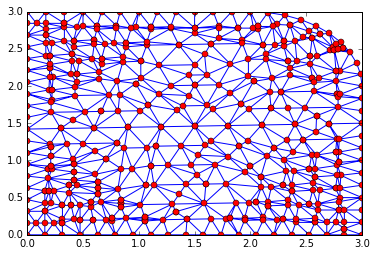

In [4]:
def plotPointsViaDelaunayTriangulation(pnts):
    
    points = numpy.array(pnts)
    tri = Delaunay(points)
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
    plt.plot(points[:,0], points[:,1], 'o')
    plt.show()
    return tri.simplices

elements3=plotPointsViaDelaunayTriangulation(points)
coordinates=numpy.array(points)

### 4. The stiffness matrix

Consider one triangle with coordinates $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$ and the basic functions $\nu_1(x,y), \nu_2(x,y), \nu_3(x,y),$ where $\nu_j(x_k, y_k)=\delta_{jk}.$

Then $$\nu_j(x, y)=det(\begin{bmatrix}
        1 & x & y\\
         1 &x_{j+1} & y_{j+1} \\
           1  &x_{j+2} & y_{j+2}
    \end{bmatrix})/det(\begin{bmatrix}
        1 & x_j & y_j\\
         1 &x_{j+1} & y_{j+1} \\
           1  &x_{j+2} & y_{j+2}
    \end{bmatrix})$$ [1, 7 p.85].
    
    

$\nabla \nu_j(x, y)=\frac{1}{2area}\begin{bmatrix}
         y_{j+1}-y_{j+2} \\
         x_{j+2} - x_{j+1} \\
    \end{bmatrix}$
    
   $ area=\frac 1 2 det\begin{bmatrix}
         x_2-x_1 & x_3-x_1\\
         y_2-y_1 & y_3-y_1 \\
    \end{bmatrix}$

The stiffness matrix equals $S^T_{jk}=\int\limits_T \nabla \nu_j\cdot\nabla \nu_kdx.$

Using the center of gravity quadrature formula we have

$S=\frac{area}{2}GG'$, where $G=\begin{bmatrix}
         1 &1&1\\
         x_1 & x_2&x_3 \\
         y_1&y_2&y_3
    \end{bmatrix}^{-1}\begin{bmatrix}
         0 & 0\\
         1&0\\
         0&1    \end{bmatrix}.$

In [5]:
def stiff(vertices):
    L=numpy.concatenate([numpy.ones((1, 3)),numpy.transpose(vertices)])
    G = numpy.dot(numpy.linalg.inv(L), numpy.concatenate ([numpy.zeros((1,2)),numpy.eye(2)]));
    return numpy.linalg.det(L) * numpy.dot(G, numpy.transpose(G)) / 2.0;

In [6]:
A=numpy.zeros((len(coordinates), len(coordinates)))

# Assembly the stiffness matrix
for j in range (0,len(elements3)):
    rows=elements3[j,:]
    columns=elements3[j,:]
    A[rows[:, numpy.newaxis], columns] = A[rows[:, numpy.newaxis], columns] + stiff(coordinates[elements3[j,:],:])

### 5. The mass matrix

As we said before $M_{ij}=\sum\limits_{E\in\mathbb{E}} \int\limits_E \xi_i  \xi_j dx.$

$M=\frac{1}{6}(area(T))\frac{1}{2}\begin{bmatrix}
         1 &1&1\\
         1 & 2&1 \\
         1&1&2
    \end{bmatrix}$ 
    
    [1, 7 p.87].

In [7]:
M=numpy.zeros((len(coordinates), len(coordinates)))

# Assembly the mass matrix
for j in range (0,len(elements3)):
    d=numpy.linalg.det(numpy.concatenate([[[1.0,1.0,1.0]],numpy.transpose(coordinates[elements3[j,:],:])]))
    rows=elements3[j,:]
    columns=elements3[j,:]
    x=numpy.array( [[2.0,1.0,1.0],[1,2.0,1.0],[1.0,1.0,2.0]])
    M[rows[:, numpy.newaxis], columns] = M[rows[:, numpy.newaxis], columns] +d * (1.0/24.0)*x

### 6. The source force and Neumann conditions

Using the triangle' center of gravity quadrature formula we get for external force and for the central point $(x_c, y_c)$

 $$\int\limits_\Omega F_n \xi_j dx=\frac{1}{6}det(\begin{bmatrix}
  x_2-x_1 &x_3-x_1\\
  y_2-y_1 & y_3-y_1 
  \end{bmatrix})f(x_c,y_c)$$
In the same way for Neumann conditions we will have
    $\int\limits_{\partial\Omega_n} V^{neum}_n \xi_jds=\frac{\text{distance between nodes}}{2} u_{neum}(x_c,y_c).$

### 7. Test example

In [8]:
# Initial parameters
T = 1.0
delta_t = 0.01
N = int(T/delta_t)


In [9]:
#Initialization
U = numpy.zeros((len(coordinates),N+1))

Setup initial conditions:

In [10]:
# Initial Condition
U[:,0] = numpy.sin(coordinates[:,0])

Setup Neumann conditions:

In [11]:
def u_neum(x,t):
    return numpy.ones((len(x)))

Setup Dirichlet conditions:

In [12]:
def u_d(x,t):
    return -t*numpy.ones((len(x)))

Setup external source:

In [13]:
def f(x,t):
    return t*numpy.ones((len(x)))

In [14]:
#time loop
for n in range(1,N+1):
    b = numpy.zeros((len(coordinates)))
    
    # External Forces
    for j in range(0,len(elements3)):
        d=numpy.linalg.det(numpy.concatenate([[[1.0,1.0,1.0]],numpy.transpose(coordinates[elements3[j,:],:])]))
        b[elements3[j,:]] = b[elements3[j,:]] +  d * delta_t*f(numpy.sum(coordinates[elements3[j,:],:], axis=1)/3.0,n*delta_t)/6.0
  

    # Neumann conditions
    for j in range(0,len(neumann)):
        b[neumann[j,:]] = b[neumann[j,:]] + numpy.linalg.norm(coordinates[neumann[j,0],:]-coordinates[neumann[j,1],:])*\
               delta_t*u_neum(numpy.sum(coordinates[neumann[j,:],:], axis=0)/2.0,n*delta_t)/2.0
  
    # previous timestep
    
    b = b + numpy.dot(M, U[:,n-1])
    
    # Dirichlet conditions 
    u = numpy.zeros((len(coordinates)))
    u[numpy.unique(dirichlet)] = u_d(coordinates[numpy.ix_(numpy.unique(dirichlet)),:], n*delta_t)
    b = b - numpy.dot((delta_t * A + M) , u)
    
    # Computation of the solution
    FreeNodes=list(set([i for i in range(len(coordinates))]) - set(numpy.unique(dirichlet)))

    #we will use sparce matrix to enable lsqr
    Q=csr_matrix(delta_t*A[numpy.ix_(FreeNodes,FreeNodes)]+ M[numpy.ix_(FreeNodes,FreeNodes)])
    #solve the system using lsqr
    u[FreeNodes] = lsqr(Q,b[FreeNodes])[0]

    U[:,n] = u

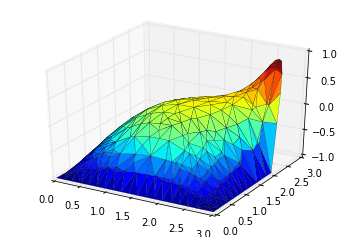

In [15]:

#plot the solution
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(coordinates[:,0], coordinates[:,1], elements3, U[:,-1], cmap=cm.jet, linewidth=0.2)

plt.show()

### 8. Encapsulation and test #2

Let collect all calculations into two fuctions: mesh calculation and solver.

In [16]:
def mesh(distance, dirichlet_coord, neumann_coord):

    points = []

    for node in dirichlet_coord:
        points.append(node)
    

    #add conditions to "points" array
    
    dirichlet_node=[]    
    for node in range(0,len(points)-1):
        dirichlet_node.append([node, node+1])

    last_dir_node=node+1

    for node in neumann_coord:
        points.append(node)
    
    neumann_node=[]
    for node in range(0,len(neumann_node)):
        neumann_node.append([node+last_dir_node, node+last_dir_node+1])
    
    
    #calculate the Delaunay grid
    splitViaDelaunay(points, distance)
    #use BC as arrays
    neumann=numpy.array(neumann_node)
    dirichlet=numpy.array(dirichlet_node)
    # list of nodes and their coordinates
    tri = Delaunay(numpy.array(points))
    elements3=tri.simplices
    coordinates=numpy.array(points)
    #return BC, list of nodes and their coordinates
    result = [dirichlet]
    result.append(neumann)
    result.append(coordinates)
    result.append(elements3)
    return result

In [17]:
def heat_FEM_sol(delta_t, t_final, U_0, f, u_neum, u_d, dirichlet, neumann, coordinates, elements3):

    
    A=numpy.zeros((len(coordinates), len(coordinates)))
    M=numpy.zeros((len(coordinates), len(coordinates)))
    T = t_final
    N = int(T/delta_t)


    for j in range (0,len(elements3)):
        rows=elements3[j,:]
        columns=elements3[j,:]
        A[rows[:, numpy.newaxis], columns] = A[rows[:, numpy.newaxis], columns] + stiff(coordinates[elements3[j,:],:])

    for j in range (0,len(elements3)):
        d=numpy.linalg.det(numpy.concatenate([[[1.0,1.0,1.0]],numpy.transpose(coordinates[elements3[j,:],:])]))
        rows=elements3[j,:]
        columns=elements3[j,:]
        x=numpy.array( [[2.0,1.0,1.0],[1,2.0,1.0],[1.0,1.0,2.0]])
        M[rows[:, numpy.newaxis], columns] = M[rows[:, numpy.newaxis], columns] +d * (1.0/24.0)*x
        
    U = numpy.zeros((len(coordinates),N+1))
    U[:,0] = U_0(coordinates)
    
    
    
    # time steps
    for n in range(1,N+1):
        b = numpy.zeros((len(coordinates)))
# External Forces
        for j in range(0,len(elements3)):
            d=numpy.linalg.det(numpy.concatenate([[[1.0,1.0,1.0]],numpy.transpose(coordinates[elements3[j,:],:])]))
            b[elements3[j,:]] = b[elements3[j,:]] + \
            d * delta_t*f(numpy.sum(coordinates[elements3[j,:],:], axis=1)/3.0,n*delta_t)/6.0
  

  # Neumann conditions
        for j in range(0,len(neumann)):
            b[neumann[j,:]] = b[neumann[j,:]] + numpy.linalg.norm(coordinates[neumann[j,0],:]-coordinates[neumann[j,1],:])*\
                   delta_t*u_neum(numpy.sum(coordinates[neumann[j,:],:], axis=0)/2.0,n*delta_t)/2.0
  
  # previous timestep
    
        b = b + numpy.dot(M, U[:,n-1])
    
# Dirichlet conditions 
        u = numpy.zeros((len(coordinates)))

        u[numpy.unique(dirichlet)] = u_d(coordinates[numpy.ix_(numpy.unique(dirichlet)),:], n*delta_t)
        b = b - numpy.dot((delta_t * A + M) , u)
    
# Computation of the solution
        FreeNodes=list(set([i for i in range(len(coordinates))]) - set(numpy.unique(dirichlet)))

        Q=csr_matrix(delta_t*A[numpy.ix_(FreeNodes,FreeNodes)]+ M[numpy.ix_(FreeNodes,FreeNodes)])
    
        u[FreeNodes] = lsqr(Q,b[FreeNodes])[0]

        U[:,n] = u
    return U[:, n]

Setup conditions:

In [18]:
def u_neum(x,t):
    return numpy.zeros((len(x)))

In [19]:
def u_d(x,t):
    return numpy.zeros((len(x)))

In [20]:
def f(x,t):
    return numpy.ones((len(x)))

In [21]:
def U_0(x):
    return numpy.ones((len(x)))

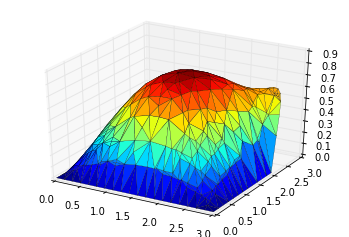

In [22]:
fig = plt.figure()
ax = fig.gca(projection='3d')
[dirichlet, neumann, coordinates, elements3]=mesh(distance, dirichlet_coord, neumann_coord)
#solution
z=heat_FEM_sol( 0.01, 1.0, U_0, f, u_neum, u_d, dirichlet, neumann, coordinates, elements3)
#plot the solution
ax.plot_trisurf(coordinates[:,0], coordinates[:,1],elements3,z, cmap=cm.jet, linewidth=0.2)

plt.show()

### 9. Stability analysis

#### A space discrete estimate

We will follow [7 Chapter V] rewriting it for 2D case. Futher we will consider the heat equation with homogeneous Dirichlet BC.  Thus the variation formulation of the problem is folllowing:
\begin{equation}
 \int\limits_\Omega v' wdx+\int\limits_\Omega \nabla v \cdot \nabla w dx = \int\limits_\Omega fw dx
\end{equation}
for fixed t.
First we derive the space discrete estimate for space discrete solution $u_h$.
Let take $w=u_h$ and thus we have
 
\begin{equation}
 \int\limits_\Omega u'_h u_h dx+\int\limits_\Omega |\nabla u_h|^2 dx = \int\limits_\Omega fu_h dx.
\end{equation}


Then $\int\limits_\Omega u'_h u_h dx=\frac{1}{2}\int\limits_\Omega (u^2_h)'dx=\frac{\partial}{2\partial t}\|u_h\|^2=\|u_h\|\frac{\partial}{\partial t}\|u_h\|.$

By the Cauchy Schwarz inequality we further have:
$$
 \int\limits_\Omega u'_h u_h dx+\int\limits_\Omega |\nabla u_h|^2 dx = \|u_h\|\frac{\partial}{\partial t}\|u_h\|+\|\nabla u_h\|^2\leq \|f\|\|u_h\|
$$

Since $0\leq\|\nabla u_h\|^2$ we have $\frac{\partial}{\partial t}\|u_h\|\leq\|f\|.$

Integrating with respect to time from 0 to t we obtain:

$\|u_h(t)\|-\|u_h(0)\|\leq \int\limits_0^t\|f\|dt$

Hence he get the upper bound on $\|u_h(t)\|$ in $L^2$:

$\|u_h(t)\|\leq\|u_h(0)\|+ \int\limits_0^t\|f\|dt$

So $\|u_h(t)\|$ is stable if $f$ hasn't "exponensial" growth. 

#### A fully discrete estimate

For fixed time we solved the heat equation using finite elements approximation:
 $V=\sum\limits_{k\in I} \nu_k \xi_k.$
And we derived the linear system to solve with respect to this approximation $V$.


$$
(hA+M)V_n=MV_{n-1}+hb_n
$$

Consider one vector $\nu^l$ of $V$ for some fixed time $n$.

$$
(hA+M)\nu_n^l=M\nu_{n-1}^l+hb_n
$$

Then we multiply by $(\nu^l_n)^T$ and we have

$$
(\nu^l_n)^T(hA+M)\nu^{T}_l=(\nu^l_n)^T(M\nu_{n-1}^l+hb_n).
$$

Clearly, it  could be obtained from the variation form that we used at the beginning: 

\begin{equation}
 \int\limits_\Omega v_n wdx+h\int\limits_\Omega \nabla v_n \cdot \nabla w dx = h\int\limits_\Omega f_{n}w dx+h\int\limits_{\partial\Omega_n} v^{neum}_n wds+\int\limits_\Omega  u_{n-1} wdx.
\end{equation}

Let take $w=v_{n,l}$, remove "neumann term" and we will have




\begin{equation}
 \int\limits_\Omega v_{n,l} v_{n,l} dx+h\int\limits_\Omega \nabla v_{n,l} \cdot \nabla v_{n,l} dx = h\int\limits_\Omega f_{n}v_{n,l} dx+\int\limits_\Omega  v_{n-1,l} v_{n,l}dx.
\end{equation}

It is the same as

$$\|v_{n,l}\|^2+h\|\nabla v_{n,l}\|^2= h\int\limits_\Omega f_{n}v_{n,l} dx+\int\limits_\Omega  v_{n-1,l} v_{n,l}dx.$$

By the Cauchy Schwarz inequality we further have:

$$\|v_{n,l}\|^2+h\|\nabla v_{n,l}\|^2\leq h\|  f_n\|\|v_{n,l}\|+\|v_{n-1,l}\|\|v_{n,l}\|.$$

Hence as before

$$\|v_{n,l}\|\leq h \|  f_n\|+\|v_{n-1,l}\|.$$

Integrating we have


$$\|v_{n,l}\|\leq h\sum\limits_{i=0}^{n}\|  f_i\|+\|v_{0,l}\|.$$

This shows that the size of $\|v_{n,l}\|$ is bounded in $L^2$ for all times by the timestep $h$, the
initial condition, and the source function $f$.

We note that more stability estimates can be found at [3, Chapter 15.3] and [5, Chapter 11.1].

### 10. Error analysis 

According to [3, Theorem 15.3] the finite elements methods should have the first order accuracy in time and second order in space with respect to inf-norm. Our mesh was chosen to ensure that triangles' sides are not larger some "maxLength". We will use this "maxLength" as a comparison value.

For comparison we need to consider some heat equation with a known solution. Also the error analysis of the FEM is provided in [7, Chapter 5.4], [8].

#### Exact solution

To check on practice error estimates we need to have some heat equation with exact solution. Consider the following equation:
\begin{equation}
\frac{\partial u}{\partial t}=\Delta u \quad \text{in }  [0,1]\times \Omega, 
\end{equation}
where $\Omega=[0,1]\times[0,1],$

with Dirichlet BC $u(t,0,y)=u(t,1,y)=u(t,x,0)=u(t,x,1)=0$

and IC $u(0,x,y)=sin(\pi x )sin(\pi y).$

Let find the solution of this equation. Assume that $u(t,x,y)=T(t)G(x,y),$ then $T'G=T \Delta G$ or $\frac{T'}{T}=\frac{\Delta G}{G}= -\lambda.$
We get that $T'=-\lambda T$ and $\Delta G+\lambda G=0.$

Now let $G(x,y)=X(x)Y(y).$ Then we have $X''Y+Y''X+\lambda XY=0$ or $\frac{X''}{X}+\frac{Y''}{Y}=-\lambda.$

Since $\frac{X''}{X}$ only depends on x, $\frac{Y''}{Y0}$ only depends on y and their sum is constant $-\lambda$ we can define $\mu, \psi$ as $\frac{X''}{X}=-\mu$ and $\frac{Y''}{Y0}=-\psi$. Thus we have $\mu + \psi = \lambda$.

Hence $X''=-\mu X$ with Dirichlet BC $X(0)=X(1)=0$. We have $\mu=(n\pi)^2$ and $X(x)=sin(n\pi x)$, $n=1,2,...$

In the same way we have $\psi=(m\pi)^2$ and $Y(y)=sin(m\pi y)$, $m=1,2,...$

We admit that $\lambda=\mu+\psi=(n\pi)^2+(m\pi)^2$ and $T(t)=e^{(-\lambda t)}$.

Thus the general solution is 

$$
u(t,x,y)=\sum\limits_{n,m=1}^{\infty} A_{nm}sin(n\pi x)sin(m\pi y)e^{(-t((n\pi)^2+(m\pi)^2))}
$$

Taking into account initial conditions we have 

$$
u(0,x,y)=\sum\limits_{n,m=1}^{\infty} A_{nm}sin(n\pi x)sin(m\pi y)=sin(\pi x )sin(\pi y)
$$

Thus $A_{nm}=1$ if $n=m=1$ and $A_{nm}=0$ otherwise. 

The solution of our equation is 

$$
u(t,x,y)=sin(\pi x)sin(\pi y)e^{-2t\pi^2}
$$

#### Numerical solution and error analysis

Now let build corresponding numerical solution.

First we need calculate the appropriate domain. To achive it we should build a mesh on our square.

Setup conditions:

In [23]:
def u_d(x,t):
    return numpy.zeros((len(x)))

In [24]:
def f(x,t):
    return numpy.zeros((len(x)))

In [25]:
def U_0(x):
    return numpy.sin(numpy.pi*x[:,0])*numpy.sin(numpy.pi*x[:,1])

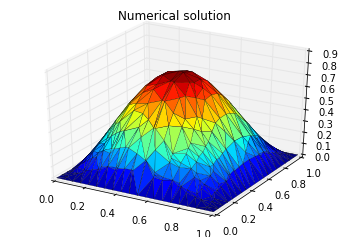

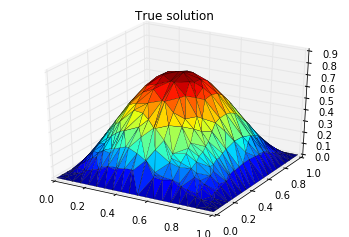

In [ ]:
m=20
delta_t=0.0001
#because of exponential decay we need to take a small time
T=0.01


lin=numpy.linspace(0.0,1.0,m)
distance=2.0*(lin[1]-lin[0])
dirichlet_coord=[]
neumann_coord=[]
#build BC
for i in range(m-1,0,-1):
    dirichlet_coord.append([lin[i], 1.0])
    
for i in range(m-1,0,-1):
    dirichlet_coord.append([0.0, lin[i]])
    
for i in range(0,m-1):
    dirichlet_coord.append([lin[i],0.0])
    
for i in range(0,m-1):
    dirichlet_coord.append([1.0,lin[i]])
    


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Numerical solution")
[dirichlet, neumann, coordinates, elements3]=mesh(distance, dirichlet_coord, neumann_coord)
#calculation of numerical solution



z=heat_FEM_sol( 0.0001, 0.01, U_0, f, u_neum, u_d, dirichlet, neumann, coordinates, elements3)
#visualizing numerical solution
ax.plot_trisurf(coordinates[:,0], coordinates[:,1],elements3,z, cmap=cm.jet, linewidth=0.2)

plt.show()

u_true = lambda t, x, y: numpy.sin(numpy.pi*x)*numpy.sin(numpy.pi*y)*numpy.exp(-2.0*t*(numpy.pi**2))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("True solution")
#visualizing true solution
ax.plot_trisurf(coordinates[:,0], coordinates[:,1],elements3,\
                u_true(0.01, coordinates[:,0], coordinates[:,1]), cmap=cm.jet, linewidth=0.2)

plt.show()


In [ ]:
# YOUR CODE HERE
# Problem setup
L=1.0
u_true = lambda t, x, y: numpy.sin(numpy.pi*x)*numpy.sin(numpy.pi*y)*numpy.exp(-2.0*t*(numpy.pi**2))


# time interval
#because of exponential decay we need to take a small final time
t_final=0.01


# Compute the error as a function of delta_x
m_range = numpy.arange(10, 15, 1)
delta_x = numpy.empty(m_range.shape)
error = numpy.empty(m_range.shape[0])
delta_t=0.0001
neumann_coord=[]

for (k, m) in enumerate(m_range):
    
    
    
    lin=numpy.linspace(0.0,1.0,m)
    distance=2.0*(lin[1]-lin[0])
    dirichlet_coord=[]
    
#calculation of BC
    for i in range(m-1,0,-1):
        dirichlet_coord.append([lin[i], 1.0])
    
    for i in range(m-1,0,-1):
        dirichlet_coord.append([0.0, lin[i]])
    
    for i in range(0,m-1):
        dirichlet_coord.append([lin[i],0.0])
    
    for i in range(0,m-1):
        dirichlet_coord.append([1.0,lin[i]])
    #grid calculation
    [dirichlet, neumann, coordinates, elements3]=mesh(distance, dirichlet_coord, neumann_coord)
    
    


    delta_x[k] = distance

    # Compute solution
    U = heat_FEM_sol( delta_t, t_final, U_0, f, u_neum, u_d, dirichlet, neumann, coordinates, elements3)

    error[k] =  numpy.linalg.norm((distance)**2*(u_true(t_final, coordinates[:,0], coordinates[:,1]) - U), numpy.inf)
    
    
    
    
    
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.set_title("Error analysis")
axes.loglog(delta_x, error[:], 'ko', label="Approx. Derivative")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc=4)
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")


plt.show()

### 11. Conslusion


In this project we justified and used the finite elements method to solve 2D heat equation with mixed boundary conditions and the source force. We used the method based on Delaunay triangulation to create the mesh. The futher analysis showed that the method is stable and has the second order accuracy in space and first in time. 

The algorithm allows to find the solution of the heat equation with an arbitrary domain, mixed BC and an arbitrary nonautonomous external forces.   


### References
[1] J. Alberty, C. Carstensen, and S. A. Funken, “Remarks around 50 lines of Matlab: short finite element implementation,” Numer. Algorithms, vol. 20, no. 2/3, pp. 117–137, 1999.

[2] J. D. Hunter, “Matplotlib: A 2D Graphics Environment,” Comput. Sci. Eng., vol. 9, no. 3, pp. 90–95, 2007.

[3] K. Eriksson, D. Estep, P. Hansbo and C. Johnson, Computational Differential Equations, Studentlitteratur, Lund, 1996.

[4] K. T. Mandli, numerical-methods-pdes, (2016), GitHub repository. [Online]. Available: https://github.com/mandli/numerical-methods-pdes. [Accessed: 04-May-2015].

[5] M. Asadzadeh, An Introduction to the Finite Element Method (FEM) for Differential Equations. Available: http://www.math.chalmers.se/~mohammad/teaching/PDEbok/draft_FEM_version4.pdf. [Accessed: 04-May-2015].

[6] M. de Berg, M. van Kreveld, M. Overmars, and O. Cheong, Computational Geometry: Algorithms and Applications. Springer-Verlag, 2008.

[7] M. G. Larson and F. Bengzon, The Finite Element Method: Theory, Implementation, and Applications, vol. 10. Berlin, Heidelberg: Springer Berlin Heidelberg, 2013.

[8] P. Ciarlet, The Finite Element Method for Elliptic Problems, NorthHolland, New York, 1980.

[9] Stevan der Walt, S. C. Colbert, and G. Varoquaux, “The NumPy Array: A Structure for Efficient Numerical Computation,” Comput. Sci. Eng., vol. 13, no. 2, pp. 22–30, Mar. 2011.

[10] “Split a triangle into smaller triangles,” http://stackoverflow.com/, 2015. [Online]. Available: http://stackoverflow.com/questions/24806221/split-a-triangle-into-smaller-triangles. [Accessed: 04-May-2015].
